For SARIMAX: 
  - Check for insignificant regressors (high p-values).
  - Check for multicollinearity (via Variance Inflation Factor – VIF).
  - Compare models with/without certain variables using AIC/BIC.

ACF vs STL:

| ACF (Autocorrelation Function)                   | STL (Seasonal-Trend decomposition using Loess)           |
| ------------------------------------------------ | -------------------------------------------------------- |
| Correlation of the series with its own past lags | Decomposes the series into trend, seasonality, residuals |
| Correlation values for lags                      | Separate time series: trend, seasonal, residual          |
| Identify autocorrelation and seasonality lags (model lags)    | Visualize and quantify seasonal and trend components     |
| Bar plot of correlations (ACF/PACF plots)        | Time series line plots of components                     |
| Peaks at lags = recurring cycles                 | Direct view of what the trend and seasonality look like  |


# ARIMA vs SARIMA vs SARIMAX

## ARIMA

Non-seasonal patterns in your time series. (p, d, q):
  - p: AR (AutoRegressive)	- How many past values (lags) the model uses to predict the current value.
  - d: Differencing - Number of times to difference the series to remove trend and make it stationary (statistical properties do not change over time: Constant mean, Constant variance, Constant autocorrelation structure)
  - q: MA (Moving Average)	- How many past forecast errors (residuals) the model uses


## SARIMA: Seasonal ARIMA

Add seasonal patterns (e.g., weekly or annual cycles) on top of ARIMA. seasonal_order=(P, D, Q, s):
  - P: Seasonal AR	- how many seasonal lags to include ("Admissions today ≈ a × Admissions 7 days ago")
  - D: Seasonal differencing - How many times to subtract seasonally (e.g., subtract value from 7 days ago)
  - Q: Seasonal MA - Use errors from prior seasonal lags to correct predictions
  - s: 	Seasonal period - 	The length of the seasonal cycle (e.g., s=7 for weekly data)

## SARIMA + exogenous variables

xog=X -> optional DataFrame of exogenous features


# Links
- https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html
- https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
- https://medium.com/data-science/time-series-forecasting-using-auto-arima-in-python-bb83e49210c

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns


from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head(5)

,DayOfWeek,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,IsDayAfterHoliday,temp_max,temp_min,temp_mean,humidity_max,humidity_min,NUMBER_INT,CO,MP10,O3,MP2.5,SO2
Date,,,,,,,,,,,,,,,,,,
2015-01-01,Thu,3,1,1,0,1,0,33.9,20.6,25.912500,89.0,32.0,30,0.0,NaN,68.0,NaN,82.0
2015-01-02,Fri,4,1,1,0,0,1,32.9,21.0,26.050000,87.0,38.0,43,0.0,NaN,79.0,NaN,83.0
2015-01-03,Sat,5,1,1,1,0,0,33.5,20.2,26.683333,83.0,38.0,23,0.0,NaN,44.0,NaN,83.0
2015-01-04,Sun,6,1,1,1,0,0,30.6,22.2,25.641667,81.0,43.0,20,0.0,NaN,49.0,NaN,82.0
2015-01-05,Mon,0,2,1,0,0,0,30.8,20.8,25.520833,79.0,36.0,51,0.0,NaN,59.0,NaN,82.0


In [4]:
# Time split: train = first 4 years, test = 5th year
min_year = df.index.year.min()
train_mask = df.index.year < (min_year + 4)
val_mask = df.index.year == (min_year + 4)

y_train = df.loc[train_mask, 'NUMBER_INT']

# Remove last 5 days from validation
y_val = df.loc[val_mask, 'NUMBER_INT'][:-5]

y_train.count()

1461

## ACF/PACF ADF

Augmented Dickey-Fuller test. Statistical test used to determine if a time series is stationary (i.e., its properties don't change over time - avg, variance, covariance).

In [5]:
y_train_diff = y_train.diff().dropna()

adf_original = adfuller(y_train)
adf_diff = adfuller(y_train_diff)

print("ADF Test (Original Series)")
print(f"Test Statistic: {adf_original[0]:.4f}")
print(f"p-value: {adf_original[1]:.4f}")
print("Stationary" if adf_original[1] < 0.05 else "Not Stationary")


ADF Test (Original Series)
Test Statistic: -2.7452
p-value: 0.0665
Not Stationary


In [6]:
print("\nADF Test (First-Differenced Series)")
print(f"Test Statistic: {adf_diff[0]:.4f}")
print(f"p-value: {adf_diff[1]:.4f}")
print("Stationary" if adf_diff[1] < 0.05 else " Not Stationary")


ADF Test (First-Differenced Series)
Test Statistic: -8.9545
p-value: 0.0000
Stationary


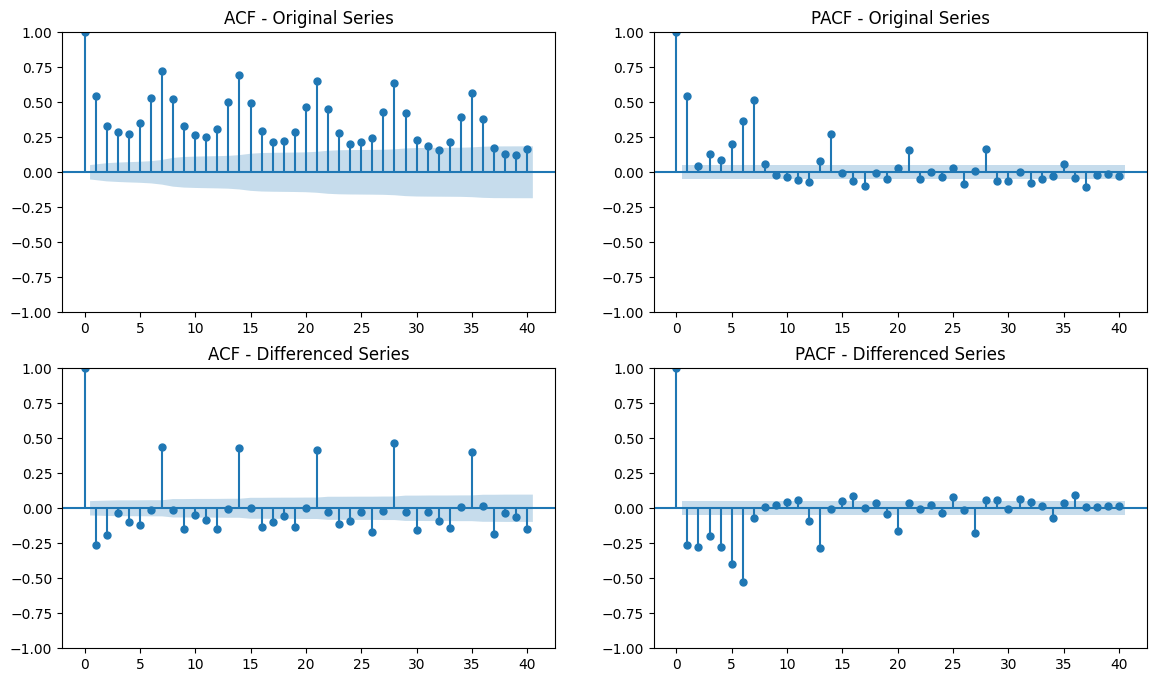

In [7]:
# Plot ACF & PACF ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

plot_acf(y_train, ax=axes[0, 0], lags=40, title='ACF - Original Series')
plot_pacf(y_train, ax=axes[0, 1], lags=40, title='PACF - Original Series')

plot_acf(y_train_diff, ax=axes[1, 0], lags=40, title='ACF - Differenced Series')
plot_pacf(y_train_diff, ax=axes[1, 1], lags=40, title='PACF - Differenced Series')

plt.show()

Based on visual inspection of ACF and PACF plots, along with ADF test results ( need for first differencing). The ARIMA model space was defined with non-seasonal orders (p, d, q) up to (...) and seasonal orders (P, D, Q) up to (...), across multiple seasonal periods. 

In [8]:
import warnings
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed")

start_time = time.time()

model = auto_arima(
    y_train,
    seasonal=True,
    m=7,
    start_p=0, max_p=15,
    start_q=0, max_q=15,
    d=1,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    max_D=1,
    stepwise=False, # Exhaustive search
    trace=True,
    # suppress_warnings=True,
    # error_action="ignore"
)

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTraining time: {elapsed:.2f} seconds")

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12002.800, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=11809.418, Time=0.56 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=11705.560, Time=0.68 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=11684.943, Time=0.15 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=11549.738, Time=0.39 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=11484.493, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=11188.102, Time=0.46 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=11028.529, Time=0.90 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=10954.750, Time=0.41 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=3.27 sec
 ARIMA(0,1,1)(2,0,0)[7] interce

 Akaike Information Criterion (AIC) is a statistical measure used to compare different statistical models for a given dataset. It estimates the relative amount of information lost when a particular model is used to represent the process that generated the data.

## Metrics for 1 year

MAE:   11.18
RMSE:  13.95
MAPE:  22.13%
SMAPE: 22.02%
R^2:   0.19
Corr:  0.54
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1461
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -5251.563
Date:                           Sat, 17 May 2025   AIC                          10517.125
Time:                                   22:46:48   BIC                          10554.129
Sample:                               01-01-2015   HQIC                         10530.929
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0015      0.004     -0.390 

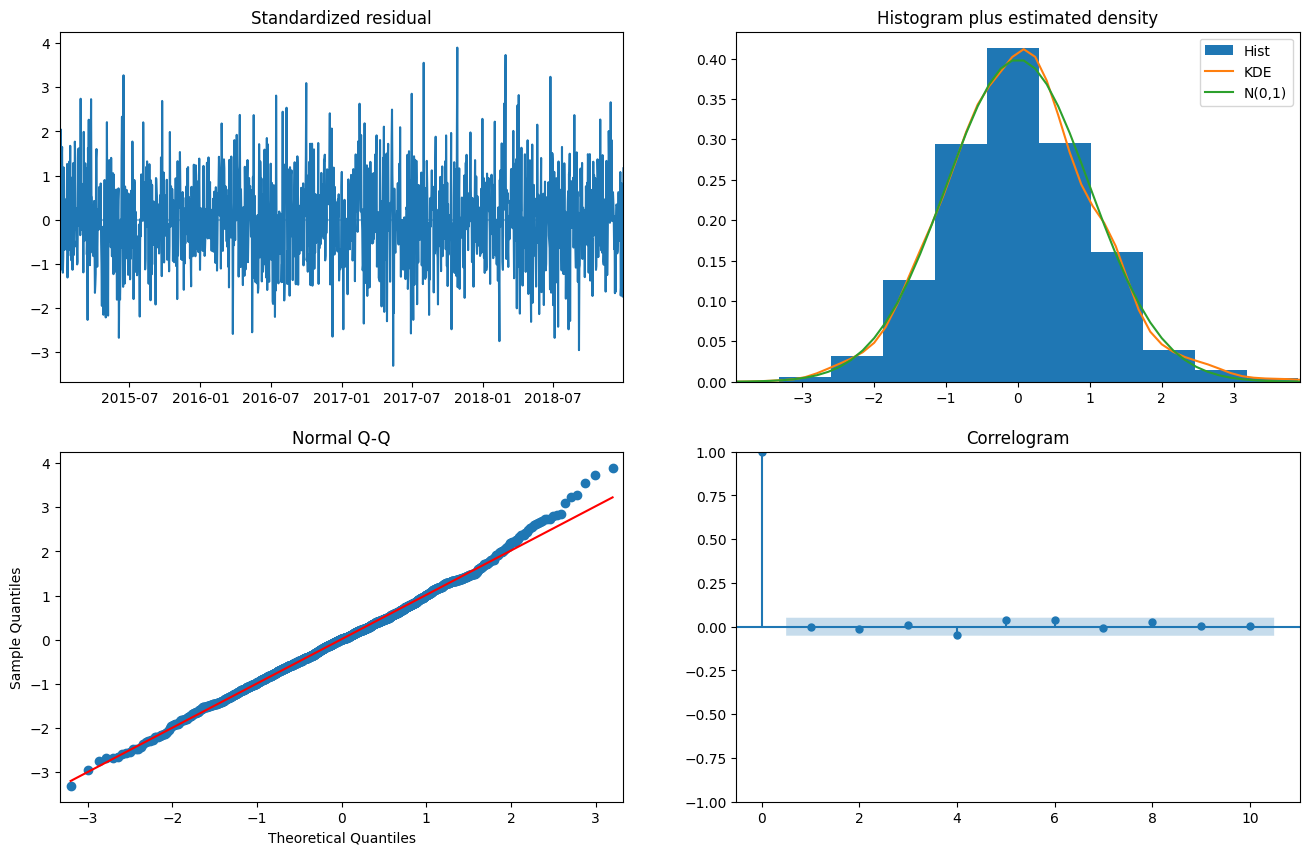

In [9]:
# Evaluate the model 1y
n_val = len(y_val)

forecast = model.predict(n_periods=n_val)

# Evaluation metrics
mse = mean_squared_error(y_val, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, forecast)
mape_val = mape(y_val, forecast)
smape_val = smape(y_val, forecast)
r2 = r2_score(y_val, forecast)
corr = np.corrcoef(y_val, forecast)[0, 1]

print(f"MAE:   {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAPE:  {mape_val:.2f}%")
print(f"SMAPE: {smape_val:.2f}%")
print(f"R^2:   {r2:.2f}")
print(f"Corr:  {corr:.2f}")

print(model.summary())

model.plot_diagnostics(figsize=(16, 10))
plt.show()

R² = 1 -  ( Total Sum of Squares (TSS) / Sum of Squared Errors (SSE) )

A Q–Q plot compares the quantiles of residuals (errors) to the quantiles of a standard normal distribution.
- residuals are normally distributed, they will fall along a 45-degree line.

## Metrics for 30 days

In [10]:
print(f"\n## Metrics for 30 days:")
forecast_30 = model.predict(n_periods=30)

# Evaluation metrics 30
mse = mean_squared_error(y_val[:30], forecast_30)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val[:30], forecast_30)
mape_val = mape(y_val[:30], forecast_30)
smape_val = smape(y_val[:30], forecast_30)
r2 = r2_score(y_val[:30], forecast_30)
corr = np.corrcoef(y_val[:30], forecast_30)[0, 1]

print(f"MAE:   {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAPE:  {mape_val:.2f}%")
print(f"SMAPE: {smape_val:.2f}%")
print(f"R^2:   {r2:.2f}")
print(f"Corr:  {corr:.2f}")


## Metrics for 30 days:
MAE:   11.81
RMSE:  13.08
MAPE:  33.08%
SMAPE: 27.18%
R^2:   -1.55
Corr:  0.75


# Graph forecast vs validation

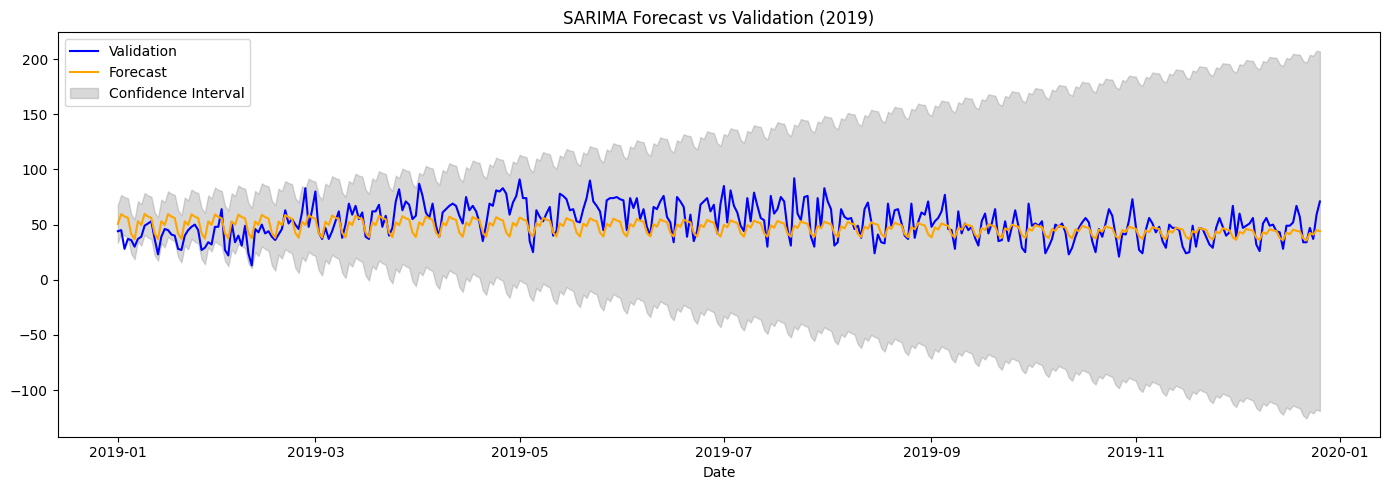

In [11]:
# Graph forecast vs validation
forecast_ci = model.predict(n_periods=n_val, return_conf_int=True)

forecast_values, conf_int = forecast_ci

forecast_index = y_val.index


plt.figure(figsize=(14, 5))
plt.plot(forecast_index, y_val, label="Validation", color="blue")
plt.plot(forecast_index, forecast_values, label="Forecast", color="orange")
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], 
                color='gray', alpha=0.3, label='Confidence Interval')
plt.title(f"SARIMA Forecast vs Validation ({forecast_index[0].year})")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

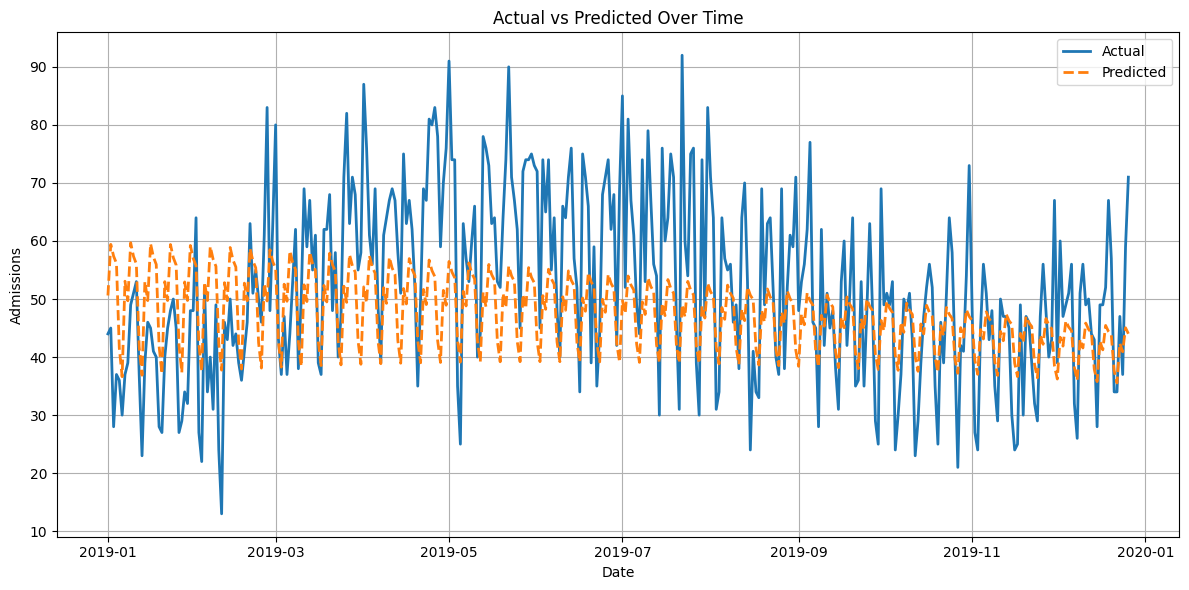

In [12]:
plt.figure(figsize=(12, 6))

plt.plot(forecast_index, y_val, label='Actual', linewidth=2)

plt.plot(forecast_index, forecast_values, label='Predicted', linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Admissions')
plt.title('Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

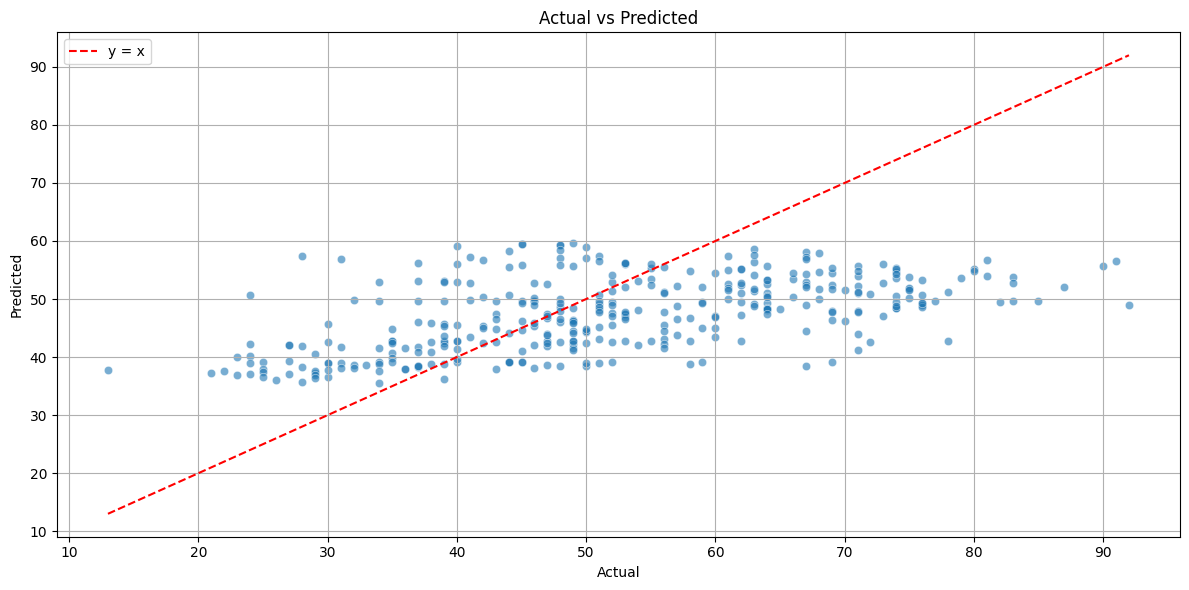

In [13]:
# Scatter plot: Actual vs Predicted admissions
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val, y=forecast_values, alpha=0.6)

plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

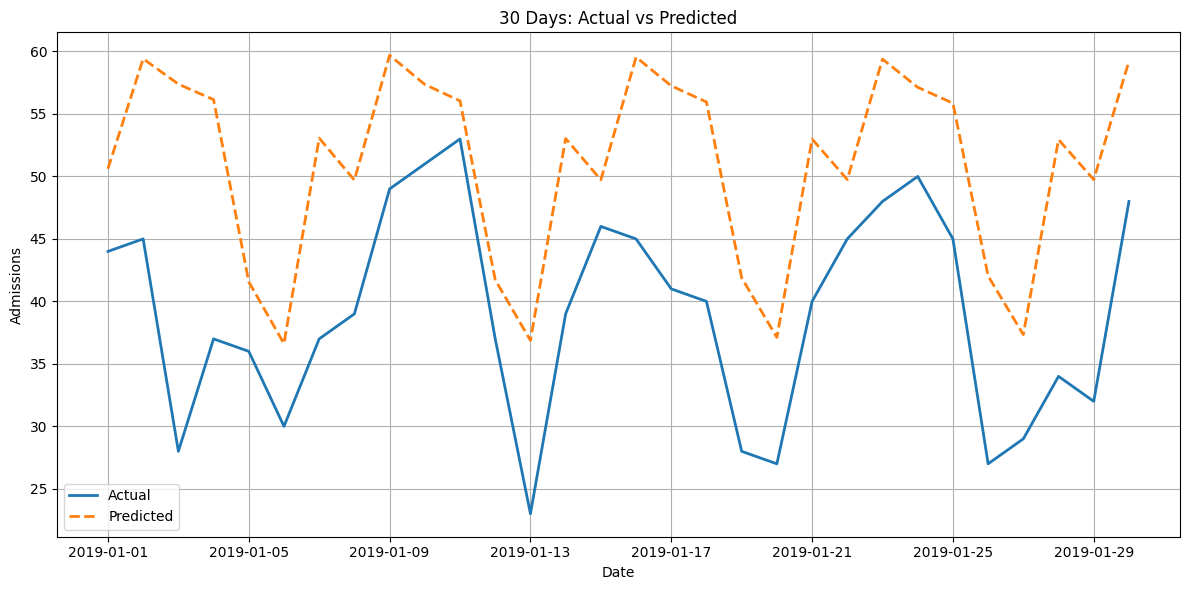

In [14]:
plt.figure(figsize=(12, 6))

plt.plot(forecast_index[:30], y_val[:30], label='Actual', linewidth=2)

plt.plot(forecast_index[:30], forecast_values[:30], label='Predicted', linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Admissions')
plt.title('30 Days: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

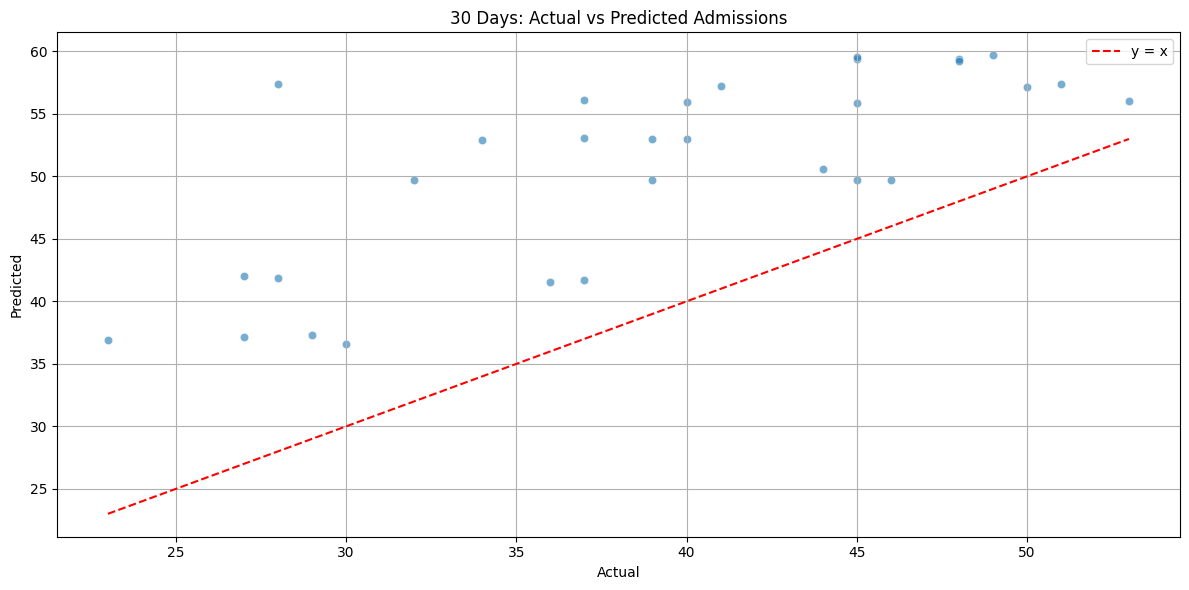

In [15]:
# Scatter plot: Actual vs Predicted admissions (first 30 days)
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:30], y=forecast_values[:30], alpha=0.6)

plt.plot([y_val[:30].min(), y_val[:30].max()], [y_val[:30].min(), y_val[:30].max()], color='red', linestyle='--', label='y = x')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('30 Days: Actual vs Predicted Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
